In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
import glob
from scipy.misc import imread
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.models import Model
from keras.models import load_model
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras import backend as K

from PIL import Image

new_style = {'grid': False}
plt.rc('axes', **new_style)
p = sns.color_palette()

Using TensorFlow backend.


In [2]:
INPUT_WIDTH = 224
INPUT_HEIGHT = 224
DATA_PATH = '/a/data/fisheries_monitoring/data/'

def load_all_labels():
    aug_folders = glob.glob(DATA_PATH + 'localizers/*')
    aug_folders = [aug_folders[5], aug_folders[7]]
    all_labels = pd.DataFrame(columns = ["img", "x","y","w","h"])
    for folder in aug_folders:
        folder_name = os.path.basename(folder)
        print "Loading data augmentation folder:", folder_name
        labels = pd.read_csv(folder + '/superboxes.csv', names = ["img", "x","y","w","h"])
        labels = labels.sort_values(by = "img")
        labels["img"] = folder_name + '/' + labels["img"]
        print "Number of examples:", len(labels)
        print
        all_labels = all_labels.append(labels)
    print "total number of examples: ", len(all_labels)
    return all_labels

all_labels = load_all_labels()

Loading data augmentation folder: original
Number of examples: 3310

Loading data augmentation folder: rotate
Number of examples: 9930

total number of examples:  13240


In [3]:
def train_val_test_split(all_labels, val_size, test_size):
    all_labels = shuffle(all_labels)
    test_labels = all_labels[0:test_size]
    val_labels = all_labels[test_size:test_size + val_size]
    train_labels = all_labels[test_size + val_size:]
    return train_labels, val_labels, test_labels

train_labels, val_labels, test_labels = train_val_test_split(all_labels, 2000, 1000)

In [4]:
def data_generator(batch_size, labels, INPUT_WIDTH, INPUT_HEIGHT):
    while True:
        img_batch = np.zeros((batch_size, INPUT_WIDTH, INPUT_HEIGHT, 3))
        box_batch = np.zeros((batch_size, 4))
        for i in xrange(batch_size):
            n = np.random.choice(len(labels))
            file_name = labels.iloc[n]["img"]
            path = DATA_PATH + 'localizers/' + file_name
            img = image.load_img(path)
            width, height = img.size
            img = img.resize((INPUT_WIDTH, INPUT_HEIGHT))
            img = image.img_to_array(img)
            img /= 255
            img_batch[i] = img
            
            old_x, old_y, old_w, old_h = labels.iloc[n][["x","y","w","h"]]
            new_x = old_x / width
            new_y = old_y / height
            new_w = old_w / width
            new_h = old_h / height
            box = np.array([new_x, new_y, new_w, new_h])
            box_batch[i] = box
        
        yield (img_batch, box_batch)

In [5]:
def load_data(labels, INPUT_WIDTH, INPUT_HEIGHT):
    X = []
    y = []
    idx = []
    X_raw = []
    y_raw = [] 
    shape_raw = []
    for i in xrange(len(labels)):
        file_name = labels.iloc[i]["img"]
        path = DATA_PATH + 'localizers/' + file_name
        img_raw = image.load_img(path)
        width, height = img_raw.size
        img = img_raw.resize((INPUT_WIDTH,INPUT_HEIGHT))
        
        img_raw = image.img_to_array(img_raw)
        img_raw /= 255
        img = image.img_to_array(img)
        img /= 255
        
        old_x, old_y, old_w, old_h = labels.iloc[i][["x","y","w","h"]]
        new_x = old_x / width
        new_y = old_y / height
        new_w = old_w / width
        new_h = old_h / height

        X.append(img)
        y.append(np.array([new_x, new_y, new_w, new_h]))
        idx.append(file_name)
        X_raw.append(img_raw)
        shape_raw.append(np.array([width, height]))
        
        if (i+1) in [k*len(labels)/5 for k in xrange(1,6)]:
                print "Loading...{}% done!".format((i+2)*100/len(labels))
        
    return np.array(X), np.array(y), np.array(idx), np.array(X_raw), np.array(shape_raw)

In [6]:
X_test, y_test, id_test, X_test_raw, shape_raw = load_data(test_labels, INPUT_WIDTH, INPUT_HEIGHT)

Loading...20% done!
Loading...40% done!
Loading...60% done!
Loading...80% done!
Loading...100% done!


## Visualizing data and boxes

In [35]:
def visualize_prediction(img, label, true_box, pred_box = None):
    figure, ax = plt.subplots(1, 1, figsize=(60, 9))
    ax.imshow(img)
    plt.title(label)
    height = img.shape[0]
    width = img.shape[1]
    
    x, y, w, h = true_box
    x = x * width
    y = y * height
    w = w * width
    h = h * height
    ax.add_patch(
    patches.Rectangle(
        (x, y), # x,y
        w, # width
        h, # height
        hatch='\\',
        fill=False      # remove background
            )
        )
    if pred_box is not None:
        x, y, w, h = pred_box
        x = x * width
        y = y * height
        w = w * width
        h = h * height
        ax.add_patch(
        patches.Rectangle(
            (x, y), # x,y
            w, # width
            h, # height
            hatch='-',
            fill=False      # remove background
                )
            )
    plt.savefig(DATA_PATH + os.path.basename(label)[:-4] + '.eps')

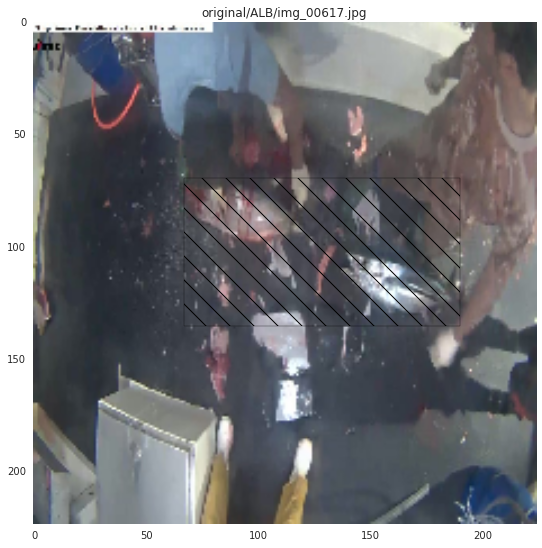

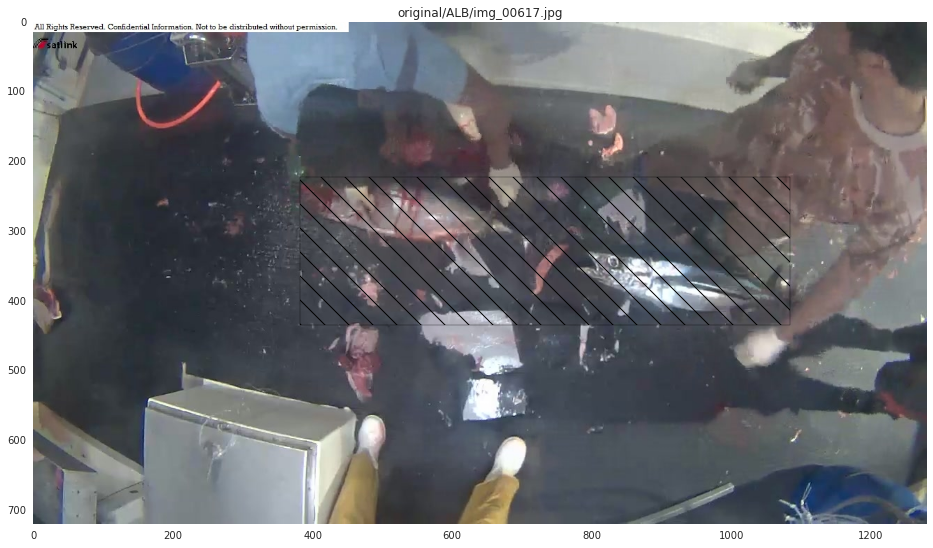

In [14]:
n = np.random.choice(len(id_test))
visualize_prediction(X_test[n],id_test[n],y_test[n])
visualize_prediction(X_test_raw[n],id_test[n],y_test[n])

## Define model

In [9]:
base_model = ResNet50(weights='imagenet', include_top = False, input_shape=(INPUT_WIDTH, INPUT_HEIGHT,3))

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation = 'sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='mean_squared_error')

## Start training

In [ ]:
model = load_model(DATA_PATH + 'models/localizers/localizer_ResNet50_SuperBox.h5')
batch_size = 30
steps_per_epoch = 100
nb_epoch = 30
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=0),]

model.fit_generator(generator = data_generator(batch_size, train_labels, INPUT_WIDTH, INPUT_HEIGHT), 
                    steps_per_epoch = steps_per_epoch,
                    epochs=nb_epoch,
                    verbose=1,
#                     callbacks = callbacks,
                    validation_data = data_generator(batch_size, val_labels, INPUT_WIDTH, INPUT_HEIGHT),
                    validation_steps = 30)
model.save(DATA_PATH + 'models/localizers/localizer_ResNet50_SuperBox.h5')

## Prediction and visualization

In [15]:
model = load_model(DATA_PATH + 'models/localizers/localizer_ResNet50_SuperBox.h5')
batch_size = 16
y_pred = model.predict(X_test.astype('float32'), batch_size=batch_size, verbose=2)
print "test loss:", mean_squared_error(y_test, y_pred)

test loss: 0.00550192447908


104


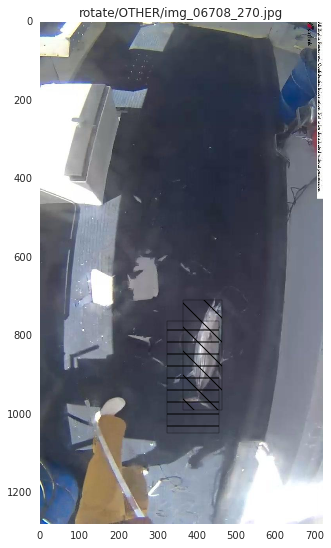

In [37]:
# The true boxes have the patch pattern of '\\' and predicted boxes have the patch pattern of '-'
for i in xrange(1):
    n = np.random.choice(len(X_test))
    print n
#     visualize_prediction(X_test[n], id_test[n], y_test[n], y_pred[n])
    visualize_prediction(X_test_raw[n], id_test[n], y_test[n], y_pred[n])